In [17]:

## Libraries and Settings

from dataclasses import dataclass, field
from typing import Dict
import os
from pathlib import Path
import re
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Stocks variables

In [18]:

@dataclass
class Settings:
    http_timeout: int = field(default_factory=lambda: int(os.getenv("HTTP_TIMEOUT", 30)))
    ecb_base: str = field(default_factory=lambda: os.getenv("ECB_API_BASE", "https://data-api.ecb.europa.eu/service"))
    tickers: Dict[str, str] = field(default_factory=dict)

    def __post_init__(self):
        self.tickers.update({
            "stoxx_eur_pts": os.getenv("YF_TICK_STOXX", "^STOXX50E"),
            "ibex_eur_pts":  os.getenv("YF_TICK_IBEX", "^IBEX"),
            "cac_eur_pts":   os.getenv("YF_TICK_CAC", "^FCHI"),
            "psi_eur_pts": os.getenv("YF_TICK_PSI", "PSI20.LS"),
        })
        self.tickers = {k.lower(): v for k, v in self.tickers.items() if v}

    def get_ticker(self, key: str) -> str:
        k = key.lower()
        if k not in self.tickers or not self.tickers[k]:
            raise KeyError(f"Missing ticker for '{key}'. Set YF_TICK_* env var.")
        return self.tickers[k]

settings = Settings()
settings.ecb_base, settings.get_ticker("cac_eur_pts")


('https://data-api.ecb.europa.eu/service', '^FCHI')

In [19]:

KEY = "D.USD.EUR.SP00.A"  # daily USD per EUR reference rate

def fetch_eur_usd(start: str, end: str, http_timeout: int = None) -> pd.DataFrame:
    base = settings.ecb_base.rstrip("/")
    url = (
        f"{base}/data/EXR/{KEY}"
        f"?startPeriod={start}&endPeriod={end}"
        f"&detail=dataonly&format=jsondata"
    )
    r = requests.get(url, timeout=http_timeout or settings.http_timeout)
    r.raise_for_status()
    data = r.json()

    time_vals = data["structure"]["dimensions"]["observation"][0]["values"]
    series_dict = data["dataSets"][0]["series"]
    rows = []
    for serie in series_dict.values():
        for idx_str, arr in serie.get("observations", {}).items():
            t = time_vals[int(idx_str)]["id"]
            v = arr[0]
            rows.append({"date": t, "eurusd": float(v)})

    fx = pd.DataFrame(rows)
    if fx.empty:
        return pd.DataFrame(columns=["date", "eurusd", "usdeur", "source"])

    # Normalize to tz-naive midnight
    fx["date"] = pd.to_datetime(fx["date"]).dt.normalize()

    fx = fx.sort_values("date").reset_index(drop=True)
    fx["usdeur"] = 1.0 / fx["eurusd"]
    fx["source"] = "ecb:data-api"
    return fx

fx_demo = fetch_eur_usd("2021-05-01", "2025-04-30")
fx_demo.head(), fx_demo.tail(), len(fx_demo)


(        date  eurusd    usdeur        source
 0 2021-05-03  1.2044  0.830289  ecb:data-api
 1 2021-05-04  1.2021  0.831878  ecb:data-api
 2 2021-05-05  1.2005  0.832986  ecb:data-api
 3 2021-05-06  1.2060  0.829187  ecb:data-api
 4 2021-05-07  1.2059  0.829256  ecb:data-api,
            date  eurusd    usdeur        source
 1021 2025-04-24  1.1376  0.879044  ecb:data-api
 1022 2025-04-25  1.1357  0.880514  ecb:data-api
 1023 2025-04-28  1.1358  0.880437  ecb:data-api
 1024 2025-04-29  1.1373  0.879275  ecb:data-api
 1025 2025-04-30  1.1373  0.879275  ecb:data-api,
 1026)

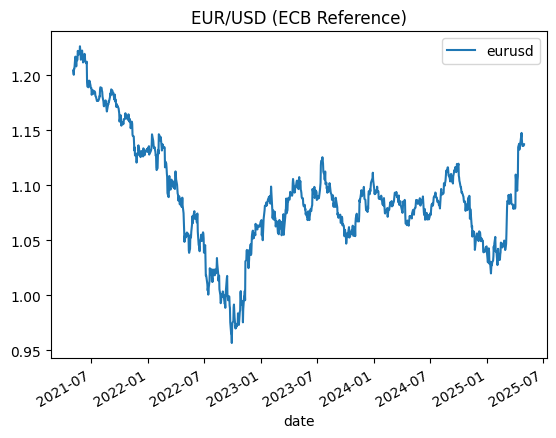

In [20]:

if not fx_demo.empty:
    fx_demo.plot(x="date", y="eurusd", title="EUR/USD (ECB Reference)")
    plt.show()
else:
    print("ECB fetch returned empty dataframe for the given dates.")


## Fetch data from `yfinance`

In [21]:
CET = "Europe/Paris"

def _normalize_dtindex_to_naive_midnight_cet(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make df.index a tz-naive midnight that represents the calendar day in CET/CEST.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        return df

    idx = df.index
    if idx.tz is not None:
        idx = idx.tz_convert(CET).tz_localize(None)  # align to CET calendar day
    else:
        # already tz-naive: treat as local day label
        idx = idx

    df = df.copy()
    df.index = idx.normalize()
    return df


def fetch(start: str, end: str) -> pd.DataFrame:
    series_key = "ibex_eur_pts"
    sym = settings.get_ticker(series_key)

    df = yf.Ticker(sym).history(start=start, end=end, auto_adjust=False)

    if df.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source"])

    # CET day labels (no UTC shift)
    df = _normalize_dtindex_to_naive_midnight_cet(df)

    out = df[["Close"]].rename(columns={"Close": "value"}).reset_index()

    # make the date column name robust
    date_col = out.columns[0]   # this is the reset index column
    out = out.rename(columns={date_col: "date"})

    out["series"] = series_key
    out["source"] = f"yahoo:{sym}"
    return out[["date", "series", "value", "source"]]


br_demo = fetch("2021-05-01", "2025-04-30")
br_demo.head(), len(br_demo)

(        date        series        value       source
 0 2021-05-03  ibex_eur_pts  8893.700195  yahoo:^IBEX
 1 2021-05-04  ibex_eur_pts  8830.400391  yahoo:^IBEX
 2 2021-05-05  ibex_eur_pts  8967.799805  yahoo:^IBEX
 3 2021-05-06  ibex_eur_pts  8982.200195  yahoo:^IBEX
 4 2021-05-07  ibex_eur_pts  9059.200195  yahoo:^IBEX,
 1023)

## Transform the series 

In [22]:
_EUR_TOKEN = re.compile(r"(?<=_)eur(?=_)")
_USD_TOKEN = re.compile(r"(?<=_)usd(?=_)")

def _is_eur_series(name: str) -> bool:
    return bool(_EUR_TOKEN.search(str(name)))

def convert_usd_to_eur(
    prices: pd.DataFrame,
    fx: pd.DataFrame,
    out_series: str,
    ffill_fx: bool = True
) -> pd.DataFrame:
    """
    Merge daily prices with ECB FX and convert to EUR.
    If the target (or input) series already indicates EUR, skip conversion and passthrough.
    """
    # empty guards
    if prices.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source", "is_estimated", "is_ffill"])

    # Normalize dates first (needed in both branches)
    prices = prices.copy()
    prices["date"] = pd.to_datetime(prices["date"])
    if getattr(prices["date"].dt, "tz", None) is not None:
        prices["date"] = prices["date"].dt.tz_convert("Europe/Paris").dt.tz_localize(None)
    prices["date"] = prices["date"].dt.normalize()


    # If target series already EUR (e.g., 'brent_eur_bbl'), or input already EUR, skip conversion
    in_series_unique = prices.get("series")
    input_is_eur = False
    if in_series_unique is not None:
        uniq = pd.Series(in_series_unique.dropna().unique(), dtype="object")
        input_is_eur = len(uniq) > 0 and all(_is_eur_series(s) for s in uniq)

    if _is_eur_series(out_series) and input_is_eur:
        out = prices[["date", "series", "value", "source"]].copy()
        # ensure output series label is exactly out_series
        out["series"] = out_series
        out["is_estimated"] = False     # no FX transformation applied
        out["is_ffill"] = False         # no FX ffill applied
        return out[["date", "series", "value", "source", "is_estimated", "is_ffill"]]

    # If we need conversion but FX is missing, return empty (consistent with original behavior)
    if fx.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source", "is_estimated", "is_ffill"])

    # --- Convert USD -> EUR ---
    fx2 = fx[["date", "usdeur"]].copy()
    fx2["date"] = pd.to_datetime(fx2["date"])
    if getattr(fx2["date"].dt, "tz", None) is not None:
        fx2["date"] = fx2["date"].dt.tz_convert("Europe/Paris").dt.tz_localize(None)
    fx2["date"] = fx2["date"].dt.normalize()
    m = prices.merge(fx2, on="date", how="left")

    m = m.sort_values("date")
    missing_before = m["usdeur"].isna()

    if ffill_fx:
        m["usdeur"] = m["usdeur"].ffill()

    m["value"] = m["value"] * m["usdeur"]
    m["series"] = out_series
    m["is_estimated"] = True
    m["is_ffill"] = missing_before

    out = m[["date", "series", "value", "source", "is_estimated", "is_ffill"]].copy()
    out = out.dropna(subset=["value"])
    return out

def add_flags(df: pd.DataFrame, estimated=False, ffill=False) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["is_estimated"] = bool(estimated)
    if "is_ffill" not in out.columns:
        out["is_ffill"] = bool(ffill)
    return out

In [23]:
br_demo_flags = add_flags(br_demo, estimated=False, ffill=False)
src_series = br_demo_flags["series"].dropna().unique()
assert len(src_series) == 1, "Expected exactly one source series."
out_series = re.sub(r"(?<=_)usd(?=_)", "eur", src_series[0])

br_eur = convert_usd_to_eur(
    br_demo_flags[["date","series","value","source"]],
    fx_demo,
    out_series=out_series,
    ffill_fx=True
)

combined = pd.concat([br_demo_flags, br_eur], ignore_index=True)
combined.sort_values("date", inplace=True)
combined.drop_duplicates(subset=["date", "series"], keep="last", inplace=True)
combined.reset_index(drop=True, inplace=True)
combined.head(10), len(combined)

(        date        series        value       source  is_estimated  is_ffill
 0 2021-05-03  ibex_eur_pts  8893.700195  yahoo:^IBEX         False     False
 1 2021-05-04  ibex_eur_pts  8830.400391  yahoo:^IBEX         False     False
 2 2021-05-05  ibex_eur_pts  8967.799805  yahoo:^IBEX         False     False
 3 2021-05-06  ibex_eur_pts  8982.200195  yahoo:^IBEX         False     False
 4 2021-05-07  ibex_eur_pts  9059.200195  yahoo:^IBEX         False     False
 5 2021-05-10  ibex_eur_pts  9144.299805  yahoo:^IBEX         False     False
 6 2021-05-11  ibex_eur_pts  8987.200195  yahoo:^IBEX         False     False
 7 2021-05-12  ibex_eur_pts  9007.700195  yahoo:^IBEX         False     False
 8 2021-05-13  ibex_eur_pts  8966.200195  yahoo:^IBEX         False     False
 9 2021-05-14  ibex_eur_pts  9145.599609  yahoo:^IBEX         False     False,
 1023)

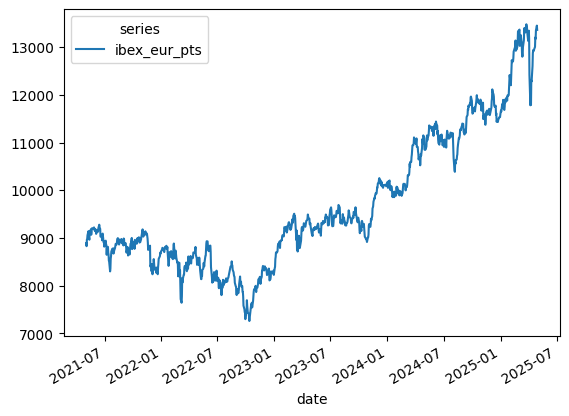

In [24]:
if not combined.empty:
    pivot = combined.pivot(index="date", columns="series", values="value")
    ax = pivot.plot()
    plt.show()
else:
    print("No combined data to plot.")


In [25]:
## Save

out_dir = Path("../data/exogenous/stocks") 
out_dir.mkdir(parents=True, exist_ok=True)

combined["date"] = pd.to_datetime(combined["date"]).dt.normalize()

for series_name, df_s in combined.groupby("series", dropna=False):
    # Make a safe filename from the series value
    name = "unknown_series" if pd.isna(series_name) or str(series_name).strip() == "" else str(series_name)
    safe = re.sub(r"[^A-Za-z0-9_.-]+", "_", name).strip("_")
    fp = out_dir / f"{safe}.parquet"

    df_s.sort_values("date").to_parquet(fp, index=False)

# ENTSO-E download: Load Forecast and Interconnection Use



**Range (inclusive): 2021‑05‑21 → 2025‑04‑30**

In [26]:
# Setup 
import os
from pathlib import Path
import pandas as pd
from entsoe import EntsoePandasClient

# Out path
OUT_DIR = "../data/exogenous/electricity"

# Minimal .env loader (so ../.env works without python-dotenv)
def load_dotenv_simple(path: str = "../.env"):
    p = Path(path)
    if not p.exists():
        return
    for line in p.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if not s or s.startswith("#") or "=" not in s:
            continue
        k, v = s.split("=", 1)
        k = k.strip()
        v = v.strip().strip('"').strip("'")
        os.environ.setdefault(k, v)

load_dotenv_simple("../.env")



TOKEN = os.environ.get("ENTSOE_API_TOKEN")
assert TOKEN, "Missing ENTSOE_API_TOKEN env var"

epy = EntsoePandasClient(api_key=TOKEN)

TZ = "Europe/Paris"
START = pd.Timestamp("2021-05-21", tz=TZ)
END_EXCL = pd.Timestamp("2025-05-01", tz=TZ) 


C:\Users\frolo\AppData\Local\Temp\ipykernel_5460\2165702461.py:31: ResourceWarning: unclosed <ssl.SSLSocket fd=3428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.120', 57329), raddr=('20.23.37.29', 443)>
  epy = EntsoePandasClient(api_key=TOKEN)


In [27]:
# Helpers 
def _to_series(x, value_name="value"):
    # entsoe-py sometimes returns Series, sometimes DataFrame
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            s = x.iloc[:, 0]
        else:
            # fallback: take first numeric column
            num_cols = x.select_dtypes("number").columns
            s = x[num_cols[0]] if len(num_cols) else x.iloc[:, 0]
    else:
        s = x
    s = s.dropna()
    s.name = value_name
    return s

def hourly_to_daily_stats(s: pd.Series, tz: str = TZ) -> pd.DataFrame:
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    if s.index.tz is None:
        s.index = s.index.tz_localize(tz)
    s_local = s.tz_convert(tz)

    # daily stats on CET/CEST days
    g = s_local.resample("D")
    out = pd.DataFrame({
        "date": g.mean().index.tz_localize(None),   # tz-naive midnight label
        "value_mean": g.mean().to_numpy(),
        "value_min":  g.min().to_numpy(),
        "value_max":  g.max().to_numpy(),
        "n_points":   g.count().to_numpy(),
        "energy_mwh": g.sum().to_numpy(),           # works if series is hourly MW
    })
    return out



### Download

In [28]:

# --- 1) Load forecast (day-ahead total load forecast) ----------------------
AREAS = ["ES", "FR", "PT"]
TZ = "Europe/Paris"
load_daily_parts = []

for a in AREAS:
    try:
        raw = epy.query_load_forecast(a, start=START, end=END_EXCL)
        s = _to_series(raw, value_name="mw")
        d = hourly_to_daily_stats(s)
        d.insert(0, "area", a)
        load_daily_parts.append(d)
        print("Load forecast OK:", a, "rows:", len(d))
    except Exception as e:
        print("Load forecast FAILED:", a, "|", repr(e))

load_daily = pd.concat(load_daily_parts, ignore_index=True) if load_daily_parts else pd.DataFrame(
    columns=["area","date_local","value_mean","value_min","value_max","n_points","energy_mwh"]
)



Load forecast OK: ES rows: 1441
Load forecast OK: FR rows: 1441
Load forecast OK: PT rows: 1441


In [29]:

# --- 2) Commercial scheduled exchanges (use of interconnection) ------------
# day-ahead commercial schedules
BORDERS = [("ES", "FR"), ("FR", "ES"), ("ES", "PT"), ("PT", "ES")]
flow_daily_parts = []

for f, t in BORDERS:
    try:
        raw = epy.query_scheduled_exchanges(f, t, start=START, end=END_EXCL, dayahead=True)
        s = _to_series(raw, value_name="mw")
        d = hourly_to_daily_stats(s)
        d.insert(0, "to_area", t)
        d.insert(0, "from_area", f)
        flow_daily_parts.append(d)
        print("Scheduled exchange OK:", f, "->", t, "rows:", len(d))
    except Exception as e:
        print("Scheduled exchange FAILED:", f, "->", t, "|", repr(e))

flow_daily = pd.concat(flow_daily_parts, ignore_index=True) if flow_daily_parts else pd.DataFrame(
    columns=["from_area","to_area","date_local","value_mean","value_min","value_max","n_points","energy_mwh"]
)


Scheduled exchange OK: ES -> FR rows: 1441
Scheduled exchange OK: FR -> ES rows: 1441
Scheduled exchange OK: ES -> PT rows: 1441
Scheduled exchange OK: PT -> ES rows: 1441


In [6]:
flow_daily

,from_area,to_area,date,value_mean,value_min,value_max,n_points,energy_mwh
0,ES,FR,2021-05-21,0.000000,0.0,0.0,24,0.0
1,ES,FR,2021-05-22,0.000000,0.0,0.0,24,0.0
2,ES,FR,2021-05-23,0.000000,0.0,0.0,24,0.0
3,ES,FR,2021-05-24,0.000000,0.0,0.0,24,0.0
4,ES,FR,2021-05-25,0.000000,0.0,0.0,24,0.0
...,...,...,...,...,...,...,...,...
5759,PT,ES,2025-04-26,436.029167,0.0,1988.8,96,41858.8
5760,PT,ES,2025-04-27,681.441667,0.0,2514.2,96,65418.4
5761,PT,ES,2025-04-28,937.620833,0.0,3327.0,96,90011.6
5762,PT,ES,2025-04-29,589.100000,0.0,2299.3,96,56553.6


In [30]:
# Compute net flow for each border (ES<->FR, FR<->ES, etc.)
def create_net_flow(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()  # Avoid modifying the original dataframe
    df["date_local"] = pd.to_datetime(df["date"]).dt.normalize()  # Ensure date is tz-naive

    # Create a unique border label
    df["border"] = df.apply(lambda r: "-".join(sorted([r["from_area"], r["to_area"]])), axis=1)

    # Pivot to get both directions (A->B, B->A) per day
    wide = df.pivot_table(index=["date_local", "border"],
                          columns=["from_area", "to_area"],
                          values="value_mean", aggfunc="mean").sort_index()

    net_flow_parts = []
    for (d, border), row in wide.iterrows():
        a, b = border.split("-")  # Get the areas
        ab = row.get((a, b), 0)  # Flow from a -> b (A->B)
        ba = row.get((b, a), 0)  # Flow from b -> a (B->A)

        # Calculate net flow: A->B - B->A
        net_flow = ab - ba  # This will give a positive value for net export from A to B

        # Create a row for net flow
        net_flow_parts.append({
            "date": d, 
            "series": f"flow_net_mw_{a}_{b}", 
            "value": net_flow
        })

    # Convert net flow list to DataFrame
    net_flow_df = pd.DataFrame(net_flow_parts)

    return net_flow_df

# Apply the function to calculate net flow
net_flow_daily = create_net_flow(flow_daily)



In [13]:
# Out path
OUT_DIR = "../data/exogenous/electricity"

# Save 
load_parquet = Path(OUT_DIR) / "entsoe_load_forecast_daily_20210521_20250430.parquet"
net_flow_parquet = Path(OUT_DIR) / "entsoe_scheduled_exchanges_net_daily_20210521_20250430.parquet"

load_daily.to_parquet(load_parquet, index=False)
net_flow_daily.to_parquet(net_flow_parquet, index=False)

print("\nLoad daily rows:", len(load_daily))
print("Net Flow daily rows:", len(net_flow_daily))


Load daily rows: 4323
Net Flow daily rows: 2882


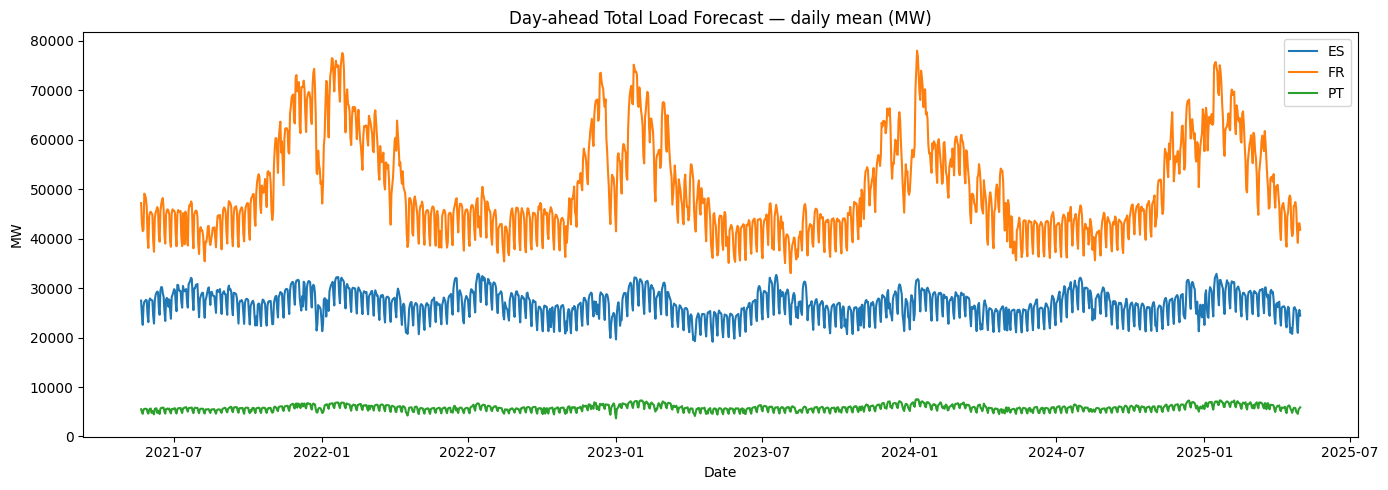

In [31]:
# 1) Load forecast (daily mean) — one line per area
if load_daily.empty:
    print("load_daily is empty")
else:
    plt.figure(figsize=(14, 5))
    for area in sorted(load_daily["area"].unique()):
        dfa = load_daily[load_daily["area"] == area].sort_values("date")
        plt.plot(dfa["date"], dfa["value_mean"], label=area)
    plt.title("Day-ahead Total Load Forecast — daily mean (MW)")
    plt.xlabel("Date")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()


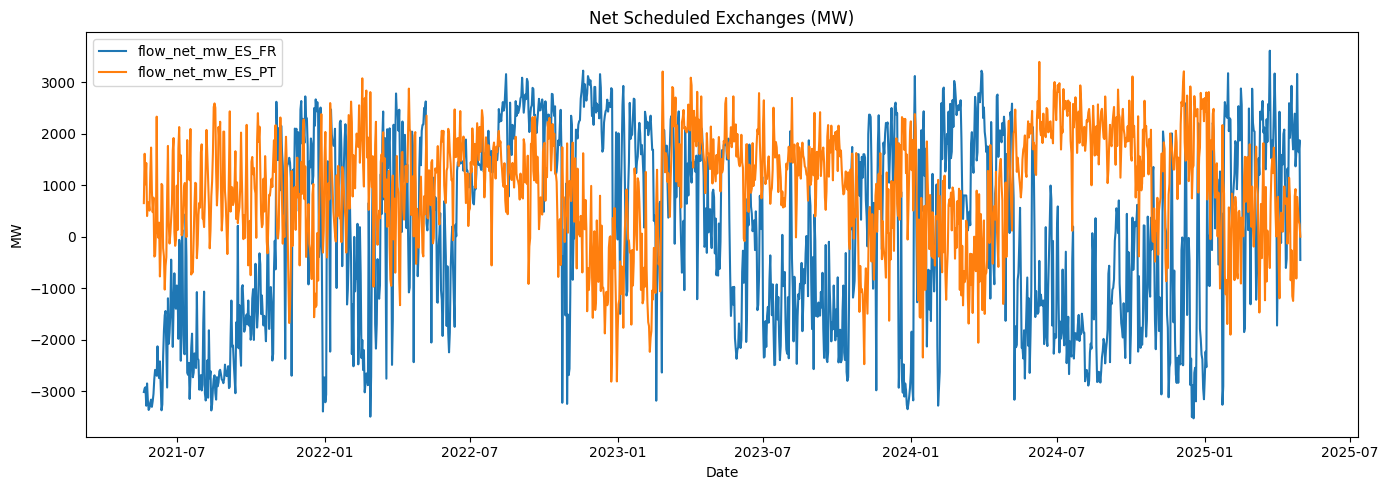

In [32]:

# 2) Scheduled exchanges (daily mean) — one plot per net direction
if net_flow_daily.empty:
    print("net_flow_daily is empty")
else:
    plt.figure(figsize=(14, 5))
    for series in sorted(net_flow_daily["series"].unique()):
        dfa = net_flow_daily[net_flow_daily["series"] == series].sort_values("date")
        plt.plot(dfa["date"], dfa["value"], label=series)
    plt.title("Net Scheduled Exchanges (MW)")
    plt.xlabel("Date")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()
 

## Iberian exception dummy

In [36]:
# Iberian exception dummy (daily)

OUT_DIR = "../data/exogenous/electricity"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# Match project’s daily sample 
sample_start = "2021-05-21"
sample_end   = "2025-04-30"

ie_start = pd.Timestamp("2022-06-15").date()
ie_end   = pd.Timestamp("2023-02-26").date()

dates = pd.date_range(sample_start, sample_end, freq="D").date

df_ie = pd.DataFrame({"date_local": dates})
df_ie["iberian_exception"] = ((df_ie["date_local"] >= ie_start) & (df_ie["date_local"] <= ie_end)).astype(int)

out_path = Path(OUT_DIR) / "iberian_exception.parquet"
df_ie.to_parquet(out_path, index=False)

print("Saved:", out_path)
df_ie.loc[(df_ie["date_local"] >= ie_start) & (df_ie["date_local"] <= ie_end)].head()


Saved: ..\data\exogenous\electricity\iberian_exception.parquet


,date_local,iberian_exception
390,2022-06-15,1
391,2022-06-16,1
392,2022-06-17,1
393,2022-06-18,1
394,2022-06-19,1


# Merge and save all

In [37]:
import numpy as np

In [38]:
FUELS_XLSX = Path("../data/exogenous/fuels/Co2CoalTTF.xlsx")
IBERIAN_EXC = Path("../data/exogenous/electricity/iberian_exception.parquet")
LOAD_DAILY = Path("../data/exogenous/electricity/entsoe_load_forecast_daily_20210521_20250430.parquet")
FLOW_DAILY = Path("../data/exogenous/electricity/entsoe_scheduled_exchanges_net_daily_20210521_20250430.parquet")
CAC = Path("../data/exogenous/stocks/cac_eur_pts.parquet")
IBEX = Path("../data/exogenous/stocks/ibex_eur_pts.parquet")
PSI = Path("../data/exogenous/stocks/psi_eur_pts.parquet")

SAMPLE_START = "2021-05-21"
SAMPLE_END   = "2025-04-30"


def prepare_exog(
    fuels_path: Path = FUELS_XLSX,
    iberian_path: Path = IBERIAN_EXC,
    load_path: Path = LOAD_DAILY,
    flow_path: Path = FLOW_DAILY,
    cac_path: Path = CAC,
    ibex_path: Path = IBEX,
    psi_path: Path = PSI,
    sample_start: str = SAMPLE_START,
    sample_end: str = SAMPLE_END,
) -> pd.DataFrame:

    # --- Fuels -------------------------------------------------------------------
    fuels = pd.read_excel(fuels_path).copy()
    fuels["date"] = pd.to_datetime(fuels["date"])
    fuels = fuels.sort_values("date")
    fuels = fuels.drop(columns=[c for c in ["year","month","day"] if c in fuels.columns])

    # --- Iberian exception --------------------------------------------------------
    ie = pd.read_parquet(iberian_path).copy()
    if "date_local" in ie.columns:
        ie["date"] = pd.to_datetime(ie["date_local"])
        ie = ie.drop(columns=["date_local"])
    else:
        ie["date"] = pd.to_datetime(ie["date"])
    ie = ie[["date","iberian_exception"]].sort_values("date")

    # --- Load (pivot to wide) -----------------------------------------------------
    load = pd.read_parquet(load_path).copy()

    # robust date column
    if "date" in load.columns:
        load["date"] = pd.to_datetime(load["date"])
    else:
        load["date"] = pd.to_datetime(load["date_local"])

    load["date"] = load["date"].dt.normalize()

    # Use DAILY ENERGY (sum of hourly MW -> MWh)
    load_wide = (
        load.pivot(index="date", columns="area", values="value_mean")
            .rename(columns=lambda a: f"load_energy_mw_{str(a).lower()}")
            .reset_index()
    )


    # --- Flows (NET scheduled exchanges: already computed in parquet) -------------
    flow = pd.read_parquet(flow_path).copy()

    # robust date column
    date_col = "date" if "date" in flow.columns else ("date_local" if "date_local" in flow.columns else flow.columns[0])
    flow[date_col] = pd.to_datetime(flow[date_col]).dt.normalize()

    # robust value column (your net file likely uses "value"; fallback to first numeric)
    if "value" in flow.columns:
        val_col = "value"
    else:
        val_col = flow.select_dtypes("number").columns[0]

    # robust series column ("series")
    series_col = "series" if "series" in flow.columns else None
    if series_col is None:
        # if you stored border as a column, adapt here; otherwise raise
        raise KeyError("Expected a 'series' column in net flow parquet (e.g., flow_net_mw_es_fr).")

    flow_wide = (
        flow[[date_col, series_col, val_col]]
        .rename(columns={date_col: "date", series_col: "series", val_col: "value"})
        .pivot(index="date", columns="series", values="value")
        .reset_index()
    )


    # --- Stocks (infer columns robustly) -----------------------------------------
    def _read_stock(path: Path, outcol: str) -> pd.DataFrame:
        s = pd.read_parquet(path).copy()
        date_col = "date" if "date" in s.columns else ("Date" if "Date" in s.columns else s.columns[0])
        s[date_col] = pd.to_datetime(s[date_col])

        for vc in ["close","Close","adjclose","Adj Close","value","Value"]:
            if vc in s.columns:
                val_col = vc
                break
        else:
            val_col = s.select_dtypes("number").columns[0]

        return s[[date_col, val_col]].rename(columns={date_col:"date", val_col: outcol}).sort_values("date")

    cac = _read_stock(cac_path, "cac_eur_pts")
    ibex = _read_stock(ibex_path, "ibex_eur_pts")
    psi = _read_stock(psi_path, "psi_eur_pts")

    # --- Merge ALL (outer) first --------------------------------------------------
    exog = fuels.merge(ie, on="date", how="outer")
    exog = exog.merge(load_wide, on="date", how="outer")
    exog = exog.merge(flow_wide, on="date", how="outer")
    exog = exog.merge(cac, on="date", how="outer")
    exog = exog.merge(ibex, on="date", how="outer")
    exog = exog.merge(psi, on="date", how="outer")

    exog["date"] = pd.to_datetime(exog["date"])
    exog = exog.sort_values("date")

    # --- Reindex to full DAILY calendar for your sample ---------------------------
    full_idx = pd.date_range(sample_start, sample_end, freq="D")
    exog = exog.set_index("date").reindex(full_idx).rename_axis("date").reset_index()

    # --- Fill rules ---------------------------------------------------------------
    # Dummy: missing days -> 0
    exog["iberian_exception"] = exog["iberian_exception"].fillna(0).astype(int)

    # Forward fill *prices / indices / fuels* (typical for non-trading / weekends)
    ffill_cols = [c for c in ["TTF","co2","coal","cac_eur_pts","ibex_eur_pts","psi_eur_pts"] if c in exog.columns]
    exog[ffill_cols] = exog[ffill_cols].ffill()

    # For load/flows: choose your policy.
    # Default: DO NOT ffill (keeps missing days as NaN so you see gaps)
    # If you want to ffill them anyway, uncomment:
    # lf_cols = [c for c in exog.columns if c.startswith("load_mean_mw_")]
    # fl_cols = [c for c in exog.columns if c.startswith("flow_mean_mw_")]
    # exog[lf_cols + fl_cols] = exog[lf_cols + fl_cols].ffill()

    # Calendar breakdown
    exog["year"] = exog["date"].dt.year
    exog["month"] = exog["date"].dt.month
    exog["day"] = exog["date"].dt.day

    # Put date columns first
    first = ["date","year","month","day","iberian_exception"]
    rest = [c for c in exog.columns if c not in first]
    exog = exog[first + rest]

    return exog

In [39]:
exog = prepare_exog()
print(exog.head())

        date  year  month  day  iberian_exception        TTF    co2  \
0 2021-05-21  2021      5   21                  0  24.790001  51.29   
1 2021-05-22  2021      5   22                  0  24.790001  51.29   
2 2021-05-23  2021      5   23                  0  24.790001  51.29   
3 2021-05-24  2021      5   24                  0  24.760000  52.68   
4 2021-05-25  2021      5   25                  0  26.190001  51.24   

        coal  load_energy_mw_es  load_energy_mw_fr  load_energy_mw_pt  \
0  69.997537       27481.958333       47206.250000        5501.958333   
1  69.997537       24528.333333       43120.833333        4970.875000   
2  69.997537       22572.791667       41512.500000        4588.625000   
3  69.954973       26303.541667       41808.333333        5414.458333   
4  69.959184       27226.625000       49120.833333        5588.791667   

   flow_net_mw_ES_FR  flow_net_mw_ES_PT  cac_eur_pts  ibex_eur_pts  \
0       -3013.416667         651.616667  6386.410156   9204.0000

In [40]:
exog.to_parquet("../data/exogenous/all_exog.parquet", index=False)


## CHECK

In [41]:
import numpy as np
import pandas as pd
from pathlib import Path

EXOG_PATH = Path("../data/exogenous/all_exog.parquet")

def check_exog(path: Path = EXOG_PATH,
               sample_start: str = "2021-05-21",
               sample_end: str = "2025-04-30") -> pd.DataFrame:
    exog = pd.read_parquet(path).copy()

    # --- Basic structure ---------------------------------------------------------
    print("Shape:", exog.shape)
    print("Columns:", exog.columns.tolist())

    # date checks
    if "date" not in exog.columns:
        raise KeyError("Missing required column 'date'.")

    exog["date"] = pd.to_datetime(exog["date"], errors="coerce")
    bad_date = exog["date"].isna().sum()
    if bad_date:
        print(f"WARNING: {bad_date} rows have non-parsable dates.")

    # ensure daily midnight labels
    not_midnight = (exog["date"].dt.hour.ne(0) | exog["date"].dt.minute.ne(0) | exog["date"].dt.second.ne(0)).sum()
    if not_midnight:
        print(f"WARNING: {not_midnight} dates are not midnight. Example:", exog.loc[
            exog["date"].dt.hour.ne(0) | exog["date"].dt.minute.ne(0) | exog["date"].dt.second.ne(0),
            "date"
        ].head(3).tolist())
    else:
        print("OK: dates are midnight (daily labels).")

    # duplicates / missing days
    dup = exog["date"].duplicated().sum()
    print("Duplicate dates:", dup)

    full = pd.date_range(sample_start, sample_end, freq="D")
    have = pd.DatetimeIndex(exog["date"].dt.normalize().dropna().unique()).sort_values()
    missing = full.difference(have)
    extra = have.difference(full)

    print("Date range in file:", have.min(), "->", have.max())
    print("Missing days in sample window:", len(missing))
    if len(missing) > 0:
        print("  First missing days:", missing[:10].to_pydatetime())
    print("Extra days outside sample window:", len(extra))
    if len(extra) > 0:
        print("  First extra days:", extra[:10].to_pydatetime())

    # --- Dtypes & numeric sanity -------------------------------------------------
    # convert numeric-looking columns that are object
    obj_cols = exog.select_dtypes(include=["object"]).columns.tolist()
    obj_cols = [c for c in obj_cols if c != "date"]
    for c in obj_cols:
        exog[c] = pd.to_numeric(exog[c], errors="ignore")

    # basic NaN summary
    na = exog.isna().sum().sort_values(ascending=False)
    na = na[na > 0]
    if len(na) == 0:
        print("OK: no missing values.")
    else:
        print("\nMissing values (top):")
        print(na.head(20))

    # infinities
    num_cols = exog.select_dtypes(include=[np.number]).columns.tolist()
    inf_cols = []
    for c in num_cols:
        if np.isinf(exog[c].to_numpy()).any():
            inf_cols.append(c)
    if inf_cols:
        print("\nWARNING: infinite values found in:", inf_cols)
    else:
        print("OK: no infinite values in numeric columns.")

    # basic summary stats (fast)
    desc = exog[num_cols].describe(percentiles=[0.01, 0.5, 0.99]).T
    desc["n_missing"] = exog[num_cols].isna().sum().values
    desc = desc.sort_values(["n_missing", "std"], ascending=[False, False])

    # --- "expectations" checks ---------------------------------------------------
    # calendar columns consistency
    for col, getter in [("year", exog["date"].dt.year), ("month", exog["date"].dt.month), ("day", exog["date"].dt.day)]:
        if col in exog.columns:
            mism = (exog[col] != getter).sum()
            if mism:
                print(f"WARNING: {mism} rows have inconsistent '{col}' vs date.")
            else:
                print(f"OK: '{col}' matches date.")

    # iberian_exception should be 0/1
    if "iberian_exception" in exog.columns:
        bad = ~exog["iberian_exception"].dropna().isin([0, 1])
        if bad.any():
            print("WARNING: iberian_exception has values outside {0,1}. Example:",
                  exog.loc[bad, "iberian_exception"].head(10).tolist())
        else:
            print("OK: iberian_exception is binary (0/1).")

    # load energy should be non-negative
    load_cols = [c for c in exog.columns if c.startswith("load_energy_mwh_")]
    if load_cols:
        neg = (exog[load_cols] < 0).sum().sum()
        if neg:
            print(f"WARNING: negative values found in load_energy columns (count={neg}).")
        else:
            print("OK: load_energy_mwh_* are non-negative (or NaN).")

    # flows: just report sign + magnitude
    flow_cols = [c for c in exog.columns if c.startswith("flow_net_")]
    if flow_cols:
        print("\nFlow net quick ranges:")
        for c in flow_cols:
            s = exog[c]
            print(f"  {c}: min={s.min(skipna=True):.3f}, max={s.max(skipna=True):.3f}, missing={s.isna().sum()}")

    # stocks/fuels: should be >0 typically (not always, but a good smoke test)
    smoke_cols = [c for c in ["TTF","co2","coal","cac_eur_pts","ibex_eur_pts","psi_eur_pts"] if c in exog.columns]
    if smoke_cols:
        print("\nPrice/index smoke checks (<=0 counts):")
        for c in smoke_cols:
            s = exog[c]
            bad = (s <= 0).sum()
            print(f"  {c}: <=0 count={bad}, missing={s.isna().sum()}")

    return desc

summary = check_exog(EXOG_PATH)
print("\n=== Summary stats table (sorted) ===")
print(summary.head(25))


Shape: (1441, 16)
Columns: ['date', 'year', 'month', 'day', 'iberian_exception', 'TTF', 'co2', 'coal', 'load_energy_mw_es', 'load_energy_mw_fr', 'load_energy_mw_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'cac_eur_pts', 'ibex_eur_pts', 'psi_eur_pts']
OK: dates are midnight (daily labels).
Duplicate dates: 0
Date range in file: 2021-05-21 00:00:00 -> 2025-04-30 00:00:00
Missing days in sample window: 0
Extra days outside sample window: 0
OK: no missing values.
OK: no infinite values in numeric columns.
OK: 'year' matches date.
OK: 'month' matches date.
OK: 'day' matches date.
OK: iberian_exception is binary (0/1).

Flow net quick ranges:
  flow_net_mw_ES_FR: min=-3524.333, max=3608.708, missing=0
  flow_net_mw_ES_PT: min=-2811.975, max=3391.550, missing=0

Price/index smoke checks (<=0 counts):
  TTF: <=0 count=0, missing=0
  co2: <=0 count=1, missing=0
  coal: <=0 count=0, missing=0
  cac_eur_pts: <=0 count=0, missing=0
  ibex_eur_pts: <=0 count=0, missing=0
  psi_eur_pts: <=0 count